In [2]:
import numpy as np
import nltk
import re
from time import time
from gensim import corpora, models, similarities
from itertools import chain
from _datetime import datetime
from lxml import etree
import json
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from math import log
from pprint import pprint as pp
from string import punctuation
from collections import defaultdict, deque
import pandas as pd
import numpy

C:\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


**Для чтения исходных данных Excel**

In [3]:
def read_data(filename):
    """Reads the given file and creates a generator object returning one line at a time split by tabulation"""
    data = pd.read_excel(filename)
    return data

**Препроцессинг**

In [4]:
with open('.\expectations_meter\english_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = [word.strip() for word in f.readlines()]

lemmatizer = WordNetLemmatizer()

numbers = re.compile('[0-9]')
punctuation += '\n—–- «»\'\"'

def lemmatize(text):
    return [lemmatizer.lemmatize(word).lower() for word in nltk.word_tokenize(text) 
            if word not in stopwords + list(punctuation)
            and word not in ["''", ' ', '``', '', "'s"]
            ]

def preprocess(text):
    # sentences = nltk.sent_tokenize(text)
    tokens = lemmatize(text.replace('\n', ' '))
    # [tokens.extend(lemmatize(sent)) for sent in sentences]
    return tokens

**Для получения токенизированных и лемматизированных данных и дат из корпуса**

In [5]:
def get_corpus(filename):
    # data = read_data(filename).iloc[:1000]
    data = read_data(filename)
    dates = data['datetime']
    # bodies = [preprocess(text) for text in list(data['body']) if not pd.isnull(text)]
    # titles = [preprocess(text) for text in list(data['title']) if not pd.isnull(text)]
    bodies = []
    for index, (title, body, author, datetime) in data.iterrows():
        if not pd.isnull(body):
            bodies.append(preprocess(body))
    return bodies, dates

**Функции для поиска ключевых слов в тексте **

In [6]:
def mark_text(words, text):
    for word in words:
        text = text.replace(word, '[<' + word + '>]')
    return text

def search_words(keywords, text):
    tokens = preprocess(text)
    keywords = set(list(chain(*preprocess(keywords))))
    intersection = list(keywords.intersection(set(list(chain(*tokens)))))
    if intersection:
        return intersection, mark_text(intersection, text), tokens

**Список всех продуктов**

Считываем список всех продуктов Apple из стороннего файла. Создаем список из tuples. Убираем все упоминания числа гигабайт в моделях, а так же типов сотовой связи, и времени выхода в году

In [8]:
def make_product_tuple(product_full_name):
    name_cleaned = ''.join([char for char in product_full_name.lower() if not char in '()\'"&']).split()
    parts_to_remove = ['gb', '+', 'late', 'early', 'mid', 'with', 'wcdma', 'cdma', 'gsm', '16', '32', '64', '128']
    name_cleaned = tuple([re.sub('([0-9])(rd|st|nd|th)', '\\1', word) for word in name_cleaned if not word in parts_to_remove])
    return name_cleaned

def read_product_list(product_list_file):
    models = defaultdict(list)
    product_list = read_data(product_list_file)
    for i, (year, launched, date_launched, model, family, discontinued) in product_list.iterrows():
        models[year].append(make_product_tuple(model))
    return models

**Поиск упоминаний продуктов из списка в корпусе**.

Проходим по каждому тексту окном в 7 токенов. Если в них встречается пересечние с любым из продуктов аорзмером 2 и больше слов, то считаем, что продукт упоминается, и добавляем его в список упоминаний для данного продукта и данной даты

In [68]:
def search_products(tokenized_text, window, product_list, year):
    product_mentions =  set()
    for i in range(window, len(tokenized_text)):
        current_window = set(tokenized_text[i-window:i])
        for y in range(year, year + 2):
            for product in product_list[y]:
                intersection = current_window.intersection(set(product)) 
                if len(intersection) >= 1:
                    product_mentions.add(tuple(product))
    return product_mentions

In [9]:
def find_mentions(dates, texts):
    mentions = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for date, (id, text) in zip(dates, enumerate(texts)):
        year = date[:4]
        date = date[:10]
        products_mentioned = search_products(text, 4, product_list, int(year))
        for product in products_mentioned:
            product_name = ' '.join(list(product))
            # mentions[product_name][date]['number'] += 1
            if 'text_ids' in  mentions[product_name][date]:
                if id not in mentions[product_name][date]['text_ids']:
                    mentions[product_name][date]['text_ids'].append(id)
                    mentions[product_name][date]['number'] += 1
            else:
                mentions[product_name][date]['text_ids'] = [id]
                mentions[product_name][date]['number'] += 1
    return mentions

**Парсим даты**

In [50]:
from datetime import datetime

def parse_date(date_string):
    # date_only = date_string[:10]
    # '2009-01-01 08:25:07'
    # 2012-01-17T17:57:00-05:00
    # Friday November 10, 2006 10:49 pm PST
    if 'T' not in date_string:
        date = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S').date()
    elif 'pst' in date_string.lower() or 'pdt' in date_string.lower():
        date = datetime.strptime(date_string[:-4], '%A %B %d, %Y %H:%M %p').date()
    else:
        date = datetime.strptime(date_string[:-6], '%Y-%m-%dT%H:%M:%S').date() 
    return date
print(parse_date('Friday November 10, 2006 10:49 pm PST'))

def parse_dates(dates):
    return [parse_date(date) for date in dates]

2006-11-10


**Визуализация**

Визуализируем распределение упоминаний продуктов по датам

In [55]:
import matplotlib.pyplot as plt
def plot_mentions(mentions, dates):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    new_dates = parse_dates(dates)
    legend = []
    for product in mentions:
        if 'macbook pro' in product:
            ment_numbers = [mentions[product][date[:10]]['number'] if date[:10] in mentions[product] else 0 for date in dates]
            plt.plot(new_dates, ment_numbers)
            legend.append(product)
    plt.legend(legend)
    plt.show()

**Собираем все вместе**

In [67]:
product_list = read_product_list('.\expectations_meter\DATA\Apple_produt_list_devices_only.xlsx')
product_list[2009][:5]

[('imac', '2009'),
 ('imac', '2009'),
 ('iphone', '3gs'),
 ('ipod', 'nano', '5', 'gen'),
 ('ipod', 'shuffle', '3', 'gen')]

In [32]:
app_ins_bodies, app_ins_dates = get_corpus('.\expectations_meter\DATA\AppleInsider.xlsx')
# app_ins_dates = pd.read_excel('.\expectations_meter\DATA\AppleInsider.xlsx')['datetime']

In [53]:
# parsed_app_ins_dates = parse_dates(app_ins_dates)

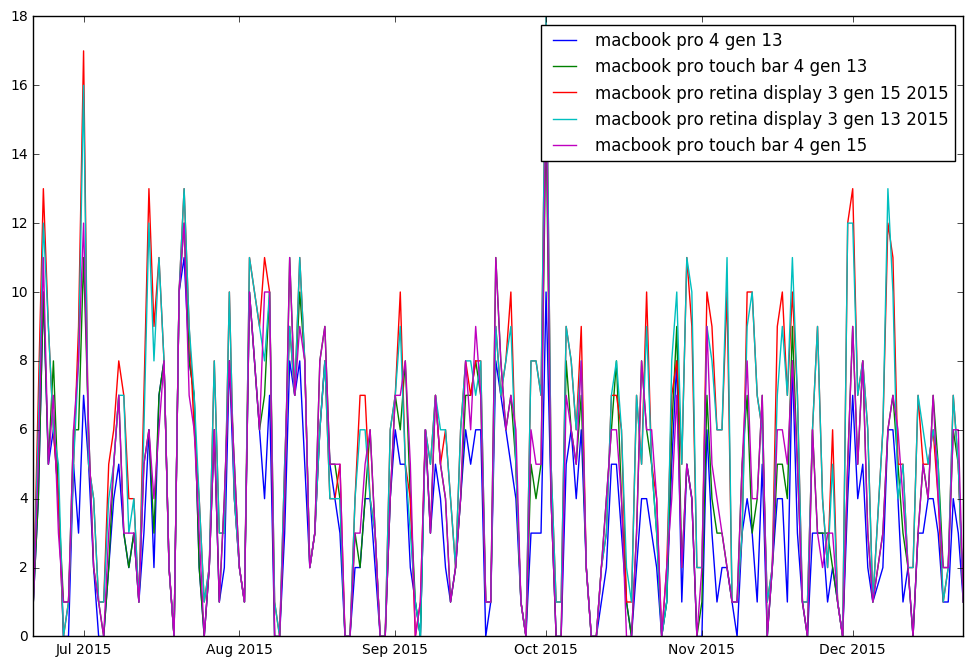

In [74]:
appins_mentions = find_mentions(app_ins_dates[20000:22000], app_ins_bodies[20000:22000])
plot_mentions(appins_mentions, app_ins_dates[20000:22000])